<a href="https://colab.research.google.com/github/thelexmeister/MIT-Applied-Data-Science-Program-Projects/blob/main/CNN_Project_Learner_Notebook_SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project - Convolutional Neural Networks: Street View Housing Number Digit Recognition**

# Marks: 30

Welcome to the project on classification using Convolutional Neural Networks. We will continue to work with the Street View Housing Numbers (SVHN) image dataset for this project.

--------------
### **Context:** 
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents. 

----------------
### **Objective:**
----------------

Build a CNN model that can identify the digits in the images.

-------------
### **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been done.

## **Mount the drive**
Let us start by mounting the drive and importing the necessary libraries.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing libraries**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras.utils import to_categorical

Let us check for the version of TensorFlow.

In [7]:
print(tf.__version__)

2.8.0


## **Load the dataset**
- Let us now load the dataset that is available as a .h5 file.
- Split the data into train and the test dataset

In [8]:
import h5py

# Open the file as read only
# User can make changes in the path as required
h5f = h5py.File('/content/drive/MyDrive/SVHN_single_grey1.h5', 'r')

# Load the training and the test set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()

Let's check the number of images in the training and testing data.

In [9]:
len(X_train), len(X_test)

(42000, 18000)

**Observations**
- There are 42,000 images in the training data and 18,000 images in the testing data. 

## **Visualizing images**
- Use X_train to visualize the first 10 images
- Use Y_train to print the first 10 labels

#### **Question 1: Complete the below code to visualize the first 10 images from the training data (1 Mark)**

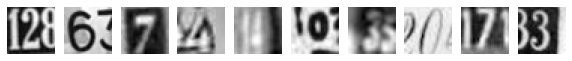

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [10]:
# visualizing the first 10 images in the dataset and their labels
plt.figure(figsize=(10, 1))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="gray") # write the function to visualize images
    plt.axis('off')

plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

## **Data Preparation**

- Print the first image in the train image and figure out the shape of the images
- Reshape the train and the test dataset to make them fit the first convolutional operation that we will create later. Figure out the required shape
- Normalize the train and the test dataset by dividing by 255
- Print the new shapes of the train and the test set
- One-hot encode the target variable

In [11]:
# Shape of the images and the first image

print("Shape:", X_train[0].shape)
print()
print("First image:\n", X_train[0])

Shape: (32, 32)

First image:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


In [12]:
# Reshaping the dataset to flatten them. Remember that we always have to give a 4D array as input to CNNs

X_train = X_train.reshape(X_train.shape[0], 32,32,1)
X_test = X_test.reshape(X_test.shape[0], 32,32,1)

In [13]:
# Normalize inputs from 0-255 to 0-1

X_train = X_train / 255.0
X_test = X_test / 255.0

In [14]:
# New shape 

print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Training set: (42000, 32, 32, 1) (42000,)
Test set: (18000, 32, 32, 1) (18000,)


#### **Question 2: One-hot encode the labels in the target variable y_train and y_test (2 Marks)**

In [15]:
#Write the function and appropriate variable name to one-hot encode the output

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#test labels
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

- Notice that each entry of y_test is a one-hot encoded vector instead of a single label.

## **Model Building**

Now, we have done data preprocessing, let's build a CNN model.

In [16]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture
 - First Convolutional layer with **16 filters and kernel size of 3x3**. Use the **'same' padding** and provide an **apt input shape**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes** and **softmax activation**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and accuracy metric**. Do not fit the model here, just return the compiled model
- Call the function and store the model in a new variable
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 32, verbose = 1, and 20 epochs**. Store the model building history to use later for visualization.

#### **Question 3: Build and train a CNN model as per the above mentioned architecture (10 Marks)**

In [17]:
#Importing losses and optimizers modules
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from keras.layers     import LeakyReLU

#Define the function
def cnn_model_1():
    model = Sequential() 
    #Add layers as per the architecture mentioned above in the same sequence
    model.add(layers.Conv2D(16, (3, 3), padding="same", input_shape=(32, 32, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(32, (3, 3), padding="same", input_shape=(32, 32, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(10, activation='softmax'))
    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate = 0.001)
    
    #compile the model
    model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [18]:
#Build the model
model_1 = cnn_model_1()

In [19]:
#Print the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                        

In [ ]:
# Fit the model
history_model_1 = model_1.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/20
1050/1050 [==============================] - 8s 7ms/step - loss: 0.6831 - accuracy: 0.7977 - val_loss: 0.6183 - val_accuracy: 0.8215
Epoch 2/20
1050/1050 [==============================] - 7s 7ms/step - loss: 0.5221 - accuracy: 0.8485 - val_loss: 0.5265 - val_accuracy: 0.8507
Epoch 3/20
1050/1050 [==============================] - 7s 7ms/step - loss: 0.4497 - accuracy: 0.8674 - val_loss: 0.5199 - val_accuracy: 0.8500
Epoch 4/20
1050/1050 [==============================] - 8s 7ms/step - loss: 0.3918 - accuracy: 0.8857 - val_loss: 0.4573 - val_accuracy: 0.8687
Epoch 5/20
1050/1050 [==============================] - 7s 7ms/step - loss: 0.3464 - accuracy: 0.8965 - val_loss: 0.4946 - val_accuracy: 0.8598
Epoch 6/20
1050/1050 [==============================] - 7s 7ms/step - loss: 0.3051 - accuracy: 0.9091 - val_loss: 0.4779 - val_accuracy: 0.8675
Epoch 7/20
1050/1050 [==============================] - 7s 7ms/step - loss: 0.2722 - accuracy: 0.9176 - val_loss: 0.4496 - val_accuracy:

### **Plotting the validation and training accuracies**

#### **Question 4: Write your observations on the below plot (2 Marks)**

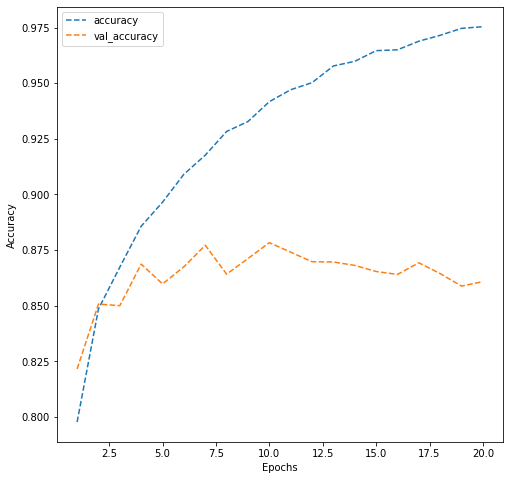

In [ ]:
# plotting the accuracies

dict_hist = history_model_1.history
list_ep = [i for i in range(1,21)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_hist['accuracy'],ls = '--', label = 'accuracy')
plt.plot(list_ep,dict_hist['val_accuracy'],ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Observations:**

First off, this model reached a 97% accuracy on the training data. However, on the validation data it only reached about an 87% accuracy. 

One concern, is that the training data appears to be just starting to level out. Running a few more epochs might be good to see if this is indeed leveling out or if it is still improving.

Each of these are better than the previous NN project results (which were both around 65%). 

I would like the model results on the validation set to be closer to the training set, so that has better generalized performance but this model is better than the previous NN.

Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the keras backend. Also, let's fix the seed again after clearing the backend.

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture
 - First Convolutional layer with **16 filters and kernel size of 3x3**. Use the **'same' padding** and provide an **apt input shape**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and kernel size of 3x3 with 'same' padding** 
 - Add a **LeakyRelu layer with slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with slope equal to 0.1**
 - Add a **dropout layer with rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes** and **softmax activation**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and accuracy metric**. Do not fit the model here, just return the compiled model
- Call the function and store the model in a new variable
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and 30 epochs**. Store the model building history to use later for visualization.

#### **Question 5: Build and train the second CNN model as per the above mentioned architecture (10 Marks)**

In [ ]:
#Define the function
def cnn_model_2():
    model = Sequential() 

    #Add layers as per the architecture mentioned above in the same sequence
    model.add(layers.Conv2D(16, (3, 3), padding="same", input_shape=(32, 32, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(32, (3, 3), padding="same", input_shape=(32, 32, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding="same", input_shape=(32, 32, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(64, (3, 3), padding="same", input_shape=(32, 32, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(layers.Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate = 0.001)

    #compile the model
    model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
# Build the model
model_2 = cnn_model_2()

In [ ]:
#Print the summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                          

In [ ]:
# Fit the model
history_model_2 = model_2.fit(X_train, y_train, epochs=30, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/30
263/263 [==============================] - 7s 22ms/step - loss: 1.4613 - accuracy: 0.5037 - val_loss: 2.2413 - val_accuracy: 0.2511
Epoch 2/30
263/263 [==============================] - 6s 21ms/step - loss: 0.6979 - accuracy: 0.7854 - val_loss: 0.5737 - val_accuracy: 0.8227
Epoch 3/30
263/263 [==============================] - 5s 21ms/step - loss: 0.5676 - accuracy: 0.8262 - val_loss: 0.4386 - val_accuracy: 0.8754
Epoch 4/30
263/263 [==============================] - 5s 21ms/step - loss: 0.4989 - accuracy: 0.8480 - val_loss: 0.4490 - val_accuracy: 0.8677
Epoch 5/30
263/263 [==============================] - 6s 21ms/step - loss: 0.4509 - accuracy: 0.8639 - val_loss: 0.3978 - val_accuracy: 0.8894
Epoch 6/30
263/263 [==============================] - 5s 21ms/step - loss: 0.4126 - accuracy: 0.8730 - val_loss: 0.4338 - val_accuracy: 0.8761
Epoch 7/30
263/263 [==============================] - 5s 21ms/step - loss: 0.3838 - accuracy: 0.8819 - val_loss: 0.4372 - val_accuracy: 0.8795

### **Plotting the validation and training accuracies**

#### **Question 6: Write your observations on the below plot (2 Marks)**

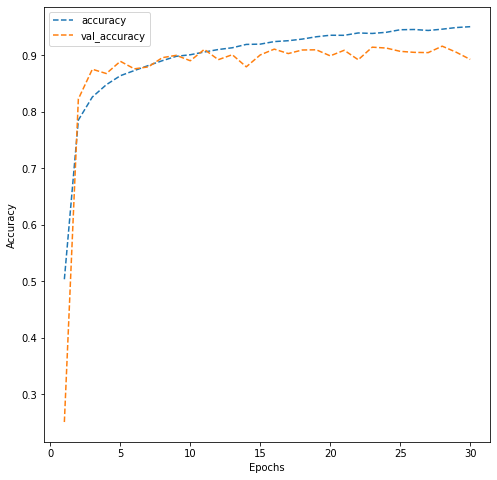

In [ ]:
# plotting the accuracies

dict_hist = history_model_2.history
list_ep = [i for i in range(1,31)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_hist['accuracy'],ls = '--', label = 'accuracy')
plt.plot(list_ep,dict_hist['val_accuracy'],ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Observations:**

These alterations to the model (the two more convolutional layers and batch normalization) resulted in a slightly lower accuracy on the training data (95% here, while it was 97% previously). However, what I mentioned before, that I wanted the model to be more generalizable, was attained with these changes. The validation data here was about 90% accurate (we'll have to see below for the actual number). That is about a 3% improvment and the two results (training and test) are more similar. 

After about 10 epochs the training data only improved slightly with each epoch. The next 20 epochs only resulted in about a 3% increase.

Therefore, I conclude this model is better than the first CNN, and much better than the NNs from the first part of this assignment. And I would recommend it is OK to move forward using this model to predict data.

## **Predictions on the test data**

- Make predictions on the test set using the second model
- Print the obtained results using the classification report and the confusion matrix
- Final observations from the obtained results

#### **Question 7: Make predictions on the test data using the second model (1 Mark)**

In [ ]:
#Make prediction on the test data using model_2 
test_pred = model_2.predict(X_test)

test_pred = np.argmax(test_pred, axis=-1)

**Note:** Earlier, we noticed that each entry of the test data is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [ ]:
#Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(y_test, axis=-1)

#### **Question 8: Write your final observations on the performance of the model on the test data (2 Marks)**

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1814
           1       0.88      0.88      0.88      1828
           2       0.91      0.90      0.90      1803
           3       0.85      0.88      0.86      1719
           4       0.88      0.92      0.90      1812
           5       0.89      0.90      0.90      1768
           6       0.91      0.85      0.88      1832
           7       0.89      0.93      0.91      1808
           8       0.90      0.87      0.88      1812
           9       0.88      0.87      0.88      1804

    accuracy                           0.89     18000
   macro avg       0.89      0.89      0.89     18000
weighted avg       0.89      0.89      0.89     18000



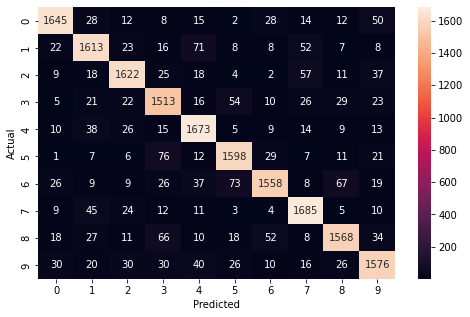

In [ ]:
#importing required functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Printing the classification report
print(classification_report(y_test, test_pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### **Observations:**

The overall accuracy of this model on the prediction set was **89%**. This is much higher than the NN from the first half of this assignment (which was **74%**). Adding the convolutional layers (and some batch normalization) improved the predictive power of the model. 

Again, because f1-score represents the overall accuracy of the model, including both precision and recall, and because this data set is not a life or death question, thus it doesn't really matter on the level of did it have more false positives or negatives, I will just discuss the f1-score, or accuracy of each number.

The model struggled the most with **3 (at 86% accuracy)**. The model most often said a **3 was a 5 (54 times)**. These could be confused by humans very easily, though.

The next numbers it struggled with **(at 88%)** accuracy were **9, 8, 6 and 1**. **9** was mislabeled pretty evenly across the other numbers. **8** was mislabeled most as a **3 (66 times)** then as a **6 (52 times)**, which are close confusers. The biggest errors for 6 were that the model predicted them to be **5 (73 times)** or **8 (67 times)**. Again, reasonable mistakes.

At a relatively high 90%, the model accurately labeled **4, 5 and 2**. The most errors with 4 was that it predicted **38 times a 4 was a 1**. For 5, the model predicted **76** times that a **5 was a 3**. The worst mistake for 2, was that the model called **57, 7s a 2**.

The model predicted **7s really well at 91% accuracy**.**45 times** it confused a **1 as a 7**. That makes a lot of sense.

Finally, the model predicted **0 the best, at 92%**, with the greatest mislabelling coming with **50, 9s labeled as 0s**.

Overall, this model did really well **(89% accuracy)** predicting the numbers from the images provided. The most mistakes for each number it made were really close confusers that even humans can make. So I would suggest this is a good model for non-significant work. If reading numbers became such a task that we needed more accuracy or errors could have much greater consequencese) we may wish to alter the parameters and layers more. But for now, this is much better than the NN (first half of this assignment) and it performs relatively well, with realistic mistakes.